In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Breast Cancer Dataset

Based on Kaggle competition https://www.kaggle.com/competitions/breast-cancer-detection/overview

In [2]:
X_raw = pd.read_csv('../data/train.csv')

We've loaded the **train** dataset. Let's take a look at our data and see which columns are unnecessary.

In [3]:
X_raw['diagnosis'].value_counts()

diagnosis
B    242
M    156
Name: count, dtype: int64

Class imbalance is present in the dataset, but AdaBoost's design allows it to perform well despite this challenge.

In [4]:
X_raw.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,3.980000e+02,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,0.0
mean,2.983734e+07,14.183236,19.274171,92.345377,660.460553,0.096540,0.104395,0.090043,0.049586,0.181707,...,25.607663,107.907688,891.912563,0.132461,0.254167,0.276683,0.116187,0.291139,0.083802,NaN
std,1.278476e+08,3.548961,4.119494,24.438949,351.641745,0.014136,0.051625,0.080718,0.039031,0.027905,...,5.947946,33.937742,577.586383,0.021980,0.148297,0.209022,0.064881,0.060838,0.016672,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.116700,...,12.020000,50.410000,185.200000,0.081250,0.034320,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.666840e+05,11.717500,16.345000,75.467500,421.275000,0.086755,0.066712,0.030090,0.020710,0.161925,...,21.392500,84.430000,516.425000,0.117275,0.147325,0.117125,0.065600,0.252625,0.072310,NaN
50%,9.052360e+05,13.445000,18.895000,86.965000,556.950000,0.095825,0.094740,0.064905,0.033950,0.180050,...,25.300000,99.165000,700.650000,0.131350,0.217000,0.238900,0.105350,0.282800,0.079960,NaN
75%,8.810979e+06,16.115000,21.695000,106.525000,802.025000,0.106075,0.130500,0.132050,0.074112,0.196550,...,29.425000,127.100000,1143.500000,0.145900,0.342675,0.386400,0.166075,0.320600,0.092075,NaN
max,9.113205e+08,27.420000,33.810000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.200600,0.932700,1.252000,0.291000,0.577400,0.148600,NaN


All numerical columns except _**Unnamed: 32**_ have some values, so they can be used. _**Unnamed: 32**_ can be dropped because it contains only **NaN** values and is not even described in the dataset instructions.

In [5]:
X_raw = X_raw.drop('Unnamed: 32', axis=1)
X_raw = X_raw.drop('id', axis=1)

In [6]:
X_raw.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

In [7]:
X_raw['diagnosis'].unique()

array(['M', 'B'], dtype=object)

Now let's deal with the **diagnosis** column; it contains two unique values (**M** = malignant, **B** = benign). As such data have an order, like *benign* being less dangerous than *malignant*, we can use `OrdinalEncoder`.

In [8]:
from sklearn.preprocessing import  OrdinalEncoder
enc = OrdinalEncoder()
X_raw['diagnosis_e'] = enc.fit_transform(X_raw[['diagnosis']])
X_raw[['diagnosis', 'diagnosis_e']].head()

,diagnosis,diagnosis_e
0,M,1.0
1,B,0.0
2,M,1.0
3,B,0.0
4,M,1.0


Now **B** -> `0` and **M** -> `1`

In [9]:
corr = X_raw.select_dtypes(include=['float64', 'int64']).corr().round(2)
px.imshow(corr, text_auto=True).show()


In [10]:
X_train = X_raw.drop(['diagnosis', 'diagnosis_e'], axis=1)
y_train = X_raw['diagnosis']

 Let's try **Random Forest** and **AdaBoost**.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
clf = RandomForestClassifier(max_depth=2, random_state=42)
cv_results = cross_validate(clf, X_train, y_train, cv=4)
cv_results


{'fit_time': array([0.51487374, 0.48888087, 0.46212101, 0.47388458]),
 'score_time': array([0.03199124, 0.03699017, 0.02998996, 0.03102493]),
 'test_score': array([0.94      , 0.89      , 0.93939394, 0.96969697])}

**GridSearchCV** helps us find the optimal parameters for our model. However, in some cases, it can cause *overfitting*.

Since the **AdaBoost** classifier gives us better results, we'll use it as our main model.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [ 30, 50, 70],
    'learning_rate': [  0.1, 0.05],
    'estimator__max_depth': [None,  2, 3]
   # 'base_estimator__min_samples_split': [2, 5, 10]
}
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
ada_clf = AdaBoostClassifier(estimator=tree_clf, n_estimators=50, learning_rate=0.5, random_state=42)
grid_search = GridSearchCV(ada_clf, param_grid, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
cv_results = cross_validate(ada_clf, X_train, y_train, cv=4)
cv_results

Best Parameters: {'estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 70}
Best Score: 0.9548232323232324


{'fit_time': array([0.60587955, 0.55685258, 0.49288058, 0.44589329]),
 'score_time': array([0.0449903 , 0.04095936, 0.0340209 , 0.03102803]),
 'test_score': array([0.97      , 0.92      , 0.95959596, 0.96969697])}

Now let's load **test** dataset for submission and make a prediction for it

In [13]:
X_test_full = pd.read_csv('../data/test.csv')
X_test = X_test_full.drop('Unnamed: 32', axis=1)
X_test = X_test.drop('id', axis=1)

Since GridSearch was slightly overfitted, we tuned the learning rate and number of estimators, achieving an accuracy of about _**0.97**_ While GridSearch best estimator gives _**0.953**_.

In [14]:
ada_clf.fit(X_train, y_train)
pred = ada_clf.predict(X_test)
submission = pd.DataFrame({
    'id': X_test_full['id'],
    'diagnosis': pred
})
submission.to_csv('../submissions/ada_submission.csv', index=False)

Now, let's perform some model exploration to identify the most valuable features. The following plots are used to understand the importance of different features in a machine learning model's predictions.

Using 171 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


100%|██████████| 171/171 [21:31<00:00,  7.56s/it]


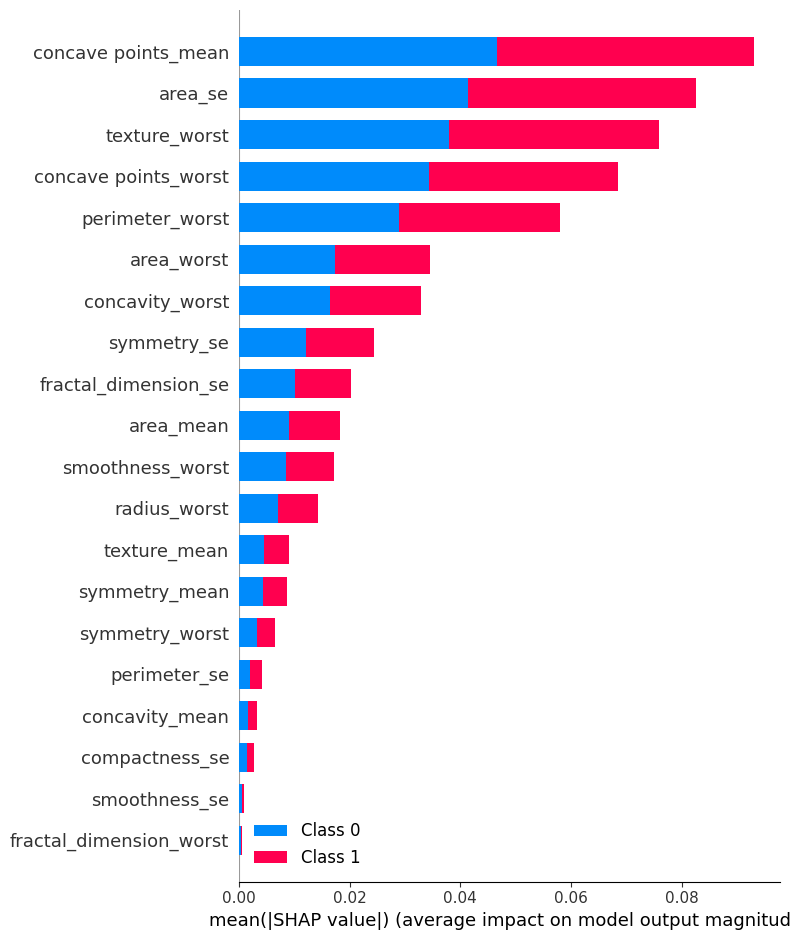

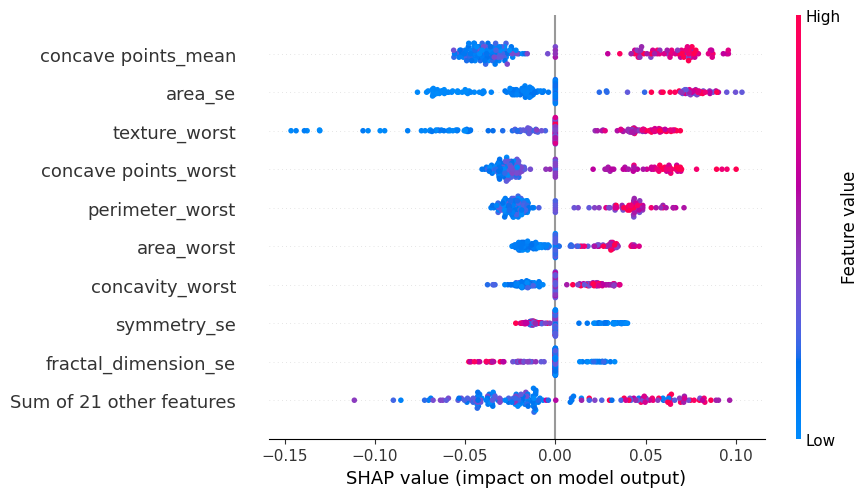

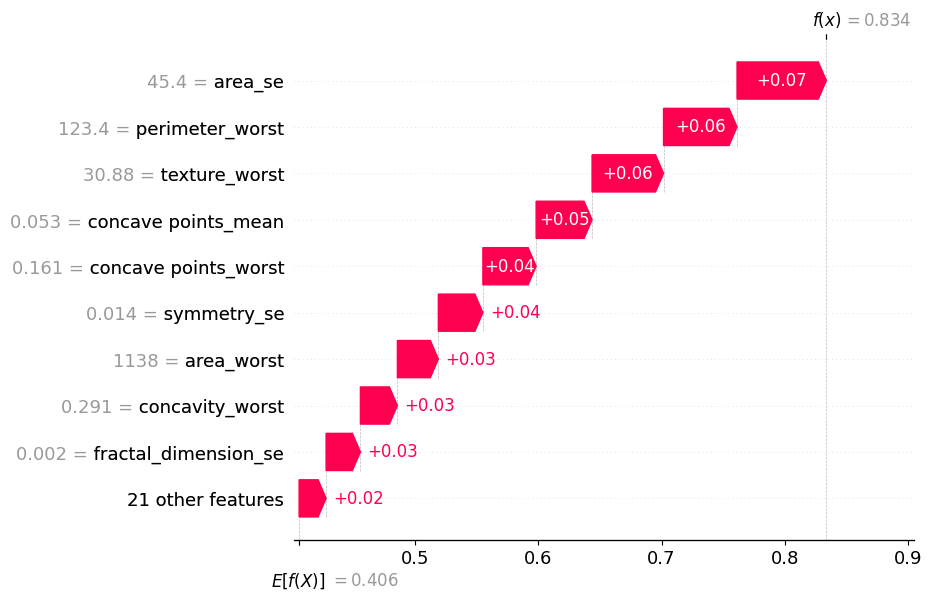

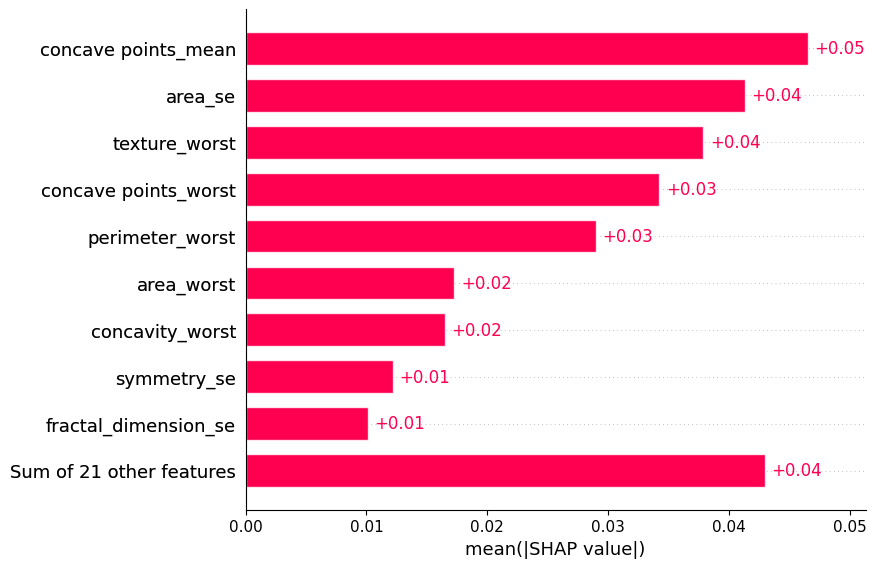

In [36]:
import shap
shap.initjs()
explainer = shap.KernelExplainer(ada_clf.predict_proba, X_test, feature_names=X_test.columns)
#AdaBoost nowork with KernelExplainer.  
#this can take a lot of time to process samples
shap_values = explainer(X_test)
shap_values_list = [shap_values.values[:, :, i] for i in range(shap_values.shape[2])]
shap.summary_plot(shap_values_list, features=X_test, plot_type="bar",
                    feature_names=X_test.columns, class_names=['Class 0', 'Class 1'])

shap.plots.beeswarm(shap_values[:, :, 1])
shap.plots.waterfall(shap_values[1, :, 1])
shap.plots.bar(shap_values[:,:,1])


As we can see from the plots **concave points_mean**, **area_se** and **texture_worst** are the most valuable features for this model. Features related to **fractal dimension standard error** had very little influence on average.